<a href="https://colab.research.google.com/github/YuToyoshima/python_samples/blob/main/pirouette_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 化学走性シミュレーション

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
num_animals = 100 # 個体数
max_time = 100    # シミュレーション時間
speed = 15        # 移動速度
turn_base = 0.01  # 方向転換パラメータ
turn_coeff = -1   # 方向転換パラメータ

width = 1000
height = 1000

### 化学物質濃度勾配を作成
濃度勾配を作成します。  
今回はピークの座標 (x, y)を設定し、ピークからの(ユークリッド)距離を濃度勾配とします。  
作成後に、試しに勾配をプロットしてみましょう。   

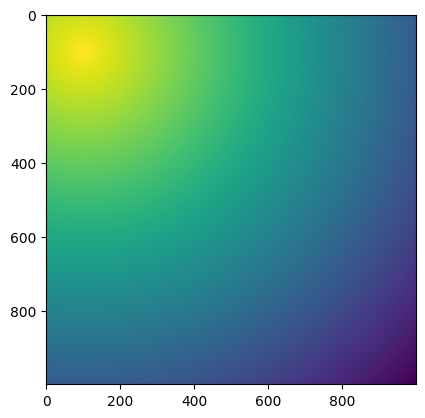

In [3]:
def set_peak(x,y):
    gradient = np.zeros([height,width])
    for h in range(height):
        for w in range(width):
            gradient[h,w] = 255 - np.sqrt((h-y)**2+ (w-x)**2)/5
    return gradient

gradient = set_peak(100,100)
plt.imshow(gradient)

### シミュレーション

線虫の行動シミュレーションを行います。  

2箇所、課題がありますので各自考えてみましょう。  
**課題1   
動物が画像の外に逃げないように、動物のx座標またはy座標が範囲を超えそうだったら、進行方向を反転させるコードを書く。**  

**課題2    
ランダムな方向転換を起こすかどうか、誘引物質の濃度変化に基づいて判断するコードを書く。**  
ヒント  
方向転換する確率は例えば以下のように計算できます。  


``` python
(誘引物質の濃度変化) * turn_coeff + turnbase
```



一定の確率pで方向転換を起こさせるには以下のようにするとできます。   

``` python
if np.random.rand() <= p:
    方向転換
```







In [6]:
from scipy.interpolate import RegularGridInterpolator
y_axis = np.arange(height)
x_axis = np.arange(width)
interpolator = RegularGridInterpolator(
    (y_axis, x_axis), gradient, bounds_error=False, fill_value=None
)
def func_gradient(y,x):
  points = np.stack([y,x],axis=-1)
  return interpolator(points)

In [7]:
trajectory_x = np.zeros((num_animals,max_time+1)) # 動物の軌跡(x座標)を記録するための配列
trajectory_y = np.zeros((num_animals,max_time+1)) # 動物の軌跡(x座標)を記録するための配列

for c in range(num_animals):
    x_old = np.random.rand()*width         # 最初のx座標を設定
    y_old = np.random.rand()*height        # 最初のy座標を設定

    #conc_old = gradient[int(y_old),int(x_old)]
    conc_old = func_gradient(y_old,x_old)

    direction = np.random.rand()*2*math.pi # 進行方向をランダムに決定
    dx = speed*np.cos(direction)           # x方向の移動量を計算
    dy = speed*np.sin(direction)           # y方向の移動量を計算

    trajectory_x[c,0] = x_old
    trajectory_y[c,0] = y_old



    for t in range(max_time):
        x_new = x_old + dx # 新しい時刻のx座標を設定
        y_new = y_old + dy # 新しい時刻のy座標を設定


        ### code here ##
        # 課題1 動物が画像の外に逃げないように、Animalのx座標またはy座標が範囲を超えそうだったら、進行方向を反転させるコードをここに書く。
        if x_new<0 or x_new>width:
          dx = -dx
          x_new = x_old+dx

        if y_new<0 or y_new>height:
          dy = -dy
          y_new = y_old+dy


        ### code end ###


        ### code here ###
        # 課題2 ランダムな方向転換を起こすかどうか、誘引物質の濃度変化に基づいて判断するコードをここに書く。
        # conc_old = gradient[int(y_old),int(x_old)]
        # conc_new = gradient[int(y_new),int(x_new)]
        conc_old = func_gradient(y_old,x_old)
        conc_new = func_gradient(y_new,x_new)
        conc_diff = conc_new-conc_old
        turn_rate = turn_coeff*conc_diff+turn_base;

        if np.random.rand() <= turn_rate:
          direction = np.random.rand()*2*math.pi # 進行方向をランダムに決定
          dx = speed*np.cos(direction)           # x方向の移動量を計算
          dy = speed*np.sin(direction)           # y方向の移動量を計算


        ### code end ###

        x_old = x_new # 時間を進めるため、1つ前の座標を現在の座標で置き換える
        y_old = y_new # 時間を進めるため、1つ前の座標を現在の座標で置き換える

        trajectory_x[c,t+1] = x_old
        trajectory_y[c,t+1] = y_old

### 軌跡のプロット

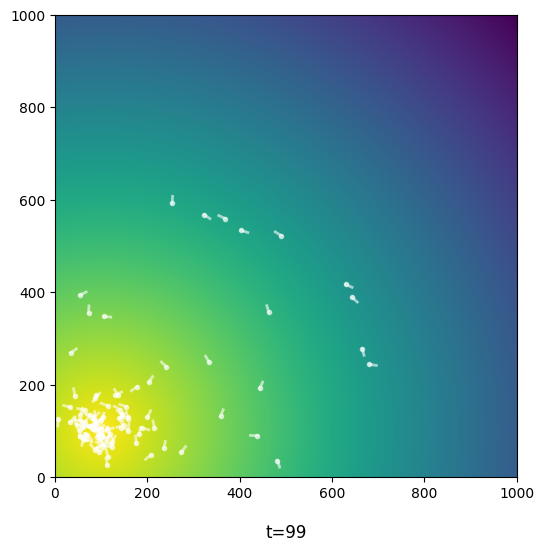

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(gradient)
head = []
body = []

for c in range(num_animals):
    h, = ax.plot(trajectory_x[c,1], trajectory_y[c,1], ".", c="white", lw=2, alpha=0.6)
    b, = ax.plot(trajectory_x[c,0:2], trajectory_y[c,0:2], "-", c="white", lw=2, alpha=0.6)
    head.append(h)
    body.append(b)

def wormplot(t):
    for c in range(num_animals):
        head[c].set_data([trajectory_x[c,t+1]], [trajectory_y[c,t+1]])
        body[c].set_data(trajectory_x[c,t:t+2], trajectory_y[c,t:t+2])  # ← 軌跡を伸ばして体に見せる
    ax.set_xlim(0, 1000)
    ax.set_ylim(0, 1000)
    ax.set_title(f't={t}', y=-0.15)
    return head + body  # アニメーションで更新対象を返すとより安定

ani = animation.FuncAnimation(fig, wormplot, interval=100, frames=max_time, blit=True)
HTML(ani.to_html5_video())

**課題3
任意の1個体が感じた化学物質濃度の時系列をプロットしてみましょう**

ヒント: float型をまとめてint型に直すには、
``` python
trajectory_x.astype(int)
```

  などとします。


**課題4
全個体が感じた化学物質濃度の時系列の平均と標準偏差をプロットしてみましょう**

ヒント: 平均値や標準偏差をデータの最初の軸について計算するには
``` python
np.mean(conc,axis=0)
np.std(conc,axis=0)
```
などとします。

Text(0, 0.5, 'Concentration')

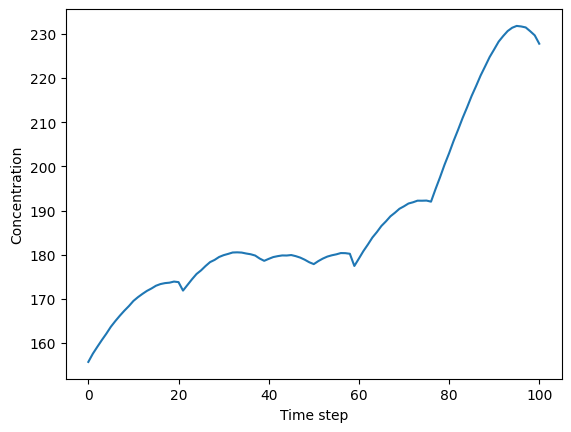

In [75]:
conc = gradient[trajectory_x[0, :].astype(int), trajectory_y[0, :].astype(int)]
plt.plot(conc)
plt.xlabel("Time step")
plt.ylabel("Concentration")


Text(0, 0.5, 'Concentration')

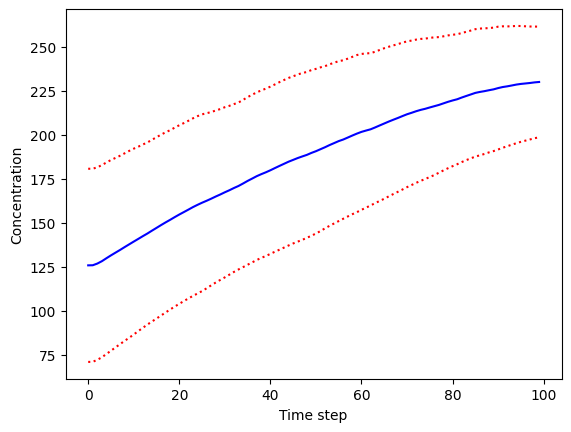

In [79]:
concAll = gradient[trajectory_x.astype(int), trajectory_y.astype(int)]
concMean = np.mean(concAll[:,:-1],axis=0)
concStd = np.std(concAll[:,:-1],axis=0)
plt.plot(range(max_time),concMean,'b-',range(max_time),concMean+concStd,'r:',range(max_time),concMean-concStd,'r:')
plt.xlabel("Time step")
plt.ylabel("Concentration")

### まとめ
おめでとうございます。走性行動のシミュレーションに成功しました！  
走性行動は動物の基本的な行動戦略のひとつです。走性行動を生み出すメカニズム(例えば方向転換確率の決め方)は多数ありますので、色々と試してみてください。  

また今回のシミュレーションは行列計算を用いることにより、より速く実行することが可能です。興味のある方は試してみてください。  